In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
from pylab import rcParams
from matplotlib import rc
from collections import Counter
from pandas.plotting import register_matplotlib_converters

<b><h1> Pre-Processing dei dati </h1></b> <br>
Si importa il dataset, rimuovono le azioni inutili e si crea un'unica label per le cadute. In seguito, si divide 80/20 per utente e divide in campioni di 151 valori per ognuno dei tre assi perché è la lunghezza fissata dei campioni nel dataset UniMiB, andando avanti di cinquanta in cinquanta.

In [ ]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
column_names = ['user_id', 'activity', 'timestamp', 'X', 'Y', 'Z']

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dataset/unimibshar.csv', header = None, names=column_names)
df.dropna(axis=0, how='any', inplace=True)

Mounted at /content/gdrive


In [ ]:
df = df[df.activity != 1]
df = df[df.activity != 2]
df = df[df.activity != 5]
df = df[df.activity != 7]
df = df[df.activity != 8]
df = df[df.activity != 16]
df = df[df.activity != 13] #rimozione delle azioni che non servono
df["activity"].loc[df.activity == 10] = "Fall"
df["activity"].loc[df.activity == 11] = "Fall"
df["activity"].loc[df.activity == 12] = "Fall"
df["activity"].loc[df.activity == 14] = "Fall"
df["activity"].loc[df.activity == 15] = "Fall" #label unica per la caduta
df["activity"].loc[df.activity == 17] = "Fall"
df["activity"].loc[df.activity == 3] = "Walking"
df["activity"].loc[df.activity == 4] = "Jogging"
df["activity"].loc[df.activity == 6] = "Hopping"
df["activity"].loc[df.activity == 9] = "Sitting"

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160737 entries, 55719 to 1777420
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1160737 non-null  int64  
 1   activity   1160737 non-null  object 
 2   timestamp  1160737 non-null  int64  
 3   X          1160737 non-null  float64
 4   Y          1160737 non-null  float64
 5   Z          1160737 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 62.0+ MB


In [ ]:
print(df["activity"].iloc[1000000])

Fall


In [ ]:
from scipy import stats
def create_dataset(X, y, time_steps=1, step=1):
  Xs, ys = [], []
  for i in range(0, len(X) - time_steps, step):
    v = X.iloc[i: (i+time_steps)].values
    labels = y.iloc[i: i+time_steps]
    Xs.append(v)
    ys.append(stats.mode(labels)[0][0])

  return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
df["user_id"].loc[df.user_id == 4] = 31
df["user_id"].loc[df.user_id == 26] = 4    #utente 26 spostato perché ha più campioni degli altri nel dataset di training
df_train = df[df['user_id'] <= 22]
df_test = df[df['user_id'] > 22]

<ipython-input-6-95a307bee54c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["user_id"].loc[df.user_id == 26] = 4    #utente 26 spostato perché ha più campioni degli altri nel dataset di training


In [ ]:
from sklearn.preprocessing import RobustScaler
scale_columns = ['X', 'Y', 'Z']
scaler = RobustScaler()
scaler = scaler.fit(df[scale_columns])
df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-7-486c4d581849>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
<ipython-input-7-486c4d581849>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
TIME_STEPS = 151
STEP = 50

In [ ]:
X_train, y_train = create_dataset(
    df_train[['X', 'Y', 'Z']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

<ipython-input-5-c98d2b2f27b9>:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-5-c98d2b2f27b9>:8: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  ys.append(stats.mode(labels)[0][0])


In [ ]:
X_test, y_test = create_dataset(
    df_test[['X', 'Y', 'Z']],
    df_test.activity,
    TIME_STEPS,
    STEP
)

<ipython-input-5-c98d2b2f27b9>:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
<ipython-input-5-c98d2b2f27b9>:8: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  ys.append(stats.mode(labels)[0][0])


In [ ]:
#stampa utile per verificare il corretto labeling in fase di visualizzazione delle metriche
print((y_test=='Fall').sum())
print((y_test=='Hopping').sum())
print((y_test=='Sitting').sum())
print((y_test=='Jogging').sum())
print((y_test=='Walking').sum())

2653
644
135
1579
1479


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 42)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)
y_val = enc.transform(y_val)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape,  X_test.shape, y_test.shape


((15047, 151, 3),
 (15047, 5),
 (1672, 151, 3),
 (1672, 5),
 (6490, 151, 3),
 (6490, 5))

In [ ]:
X_train = X_train.reshape(15047, 151, 3, 1) #reshape dei dataset di training, validation e test per aggiungere una dimensione
X_val = X_val.reshape(1672, 151, 3, 1)
X_test = X_test.reshape(6490, 151, 3, 1)

<b><h1> Classificazione </h1></b> <br>
Definizione del classificatore Convolutional Neural Network e stampa delle metriche della classificazione.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import *
import matplotlib.pyplot as plt


In [ ]:
model = Sequential()
model.add(Conv2D(8, (2, 2), activation = 'relu', input_shape = X_train[0].shape))

model.add(Conv2D(16, (2, 2), activation = 'relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (2, 2), activation = 'relu', padding='same'))
model.add(BatchNormalization())

model.add(Flatten())


model.add(Dense(16, activation = 'relu'))

model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', f1_m, recall_m, precision_m])

In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs = 14, validation_data= (X_val, y_val), verbose=1)
rounded_labels=np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=-1)
f1=[]
acc=[]
from sklearn.metrics import accuracy_score, f1_score
acc.append(accuracy_score(rounded_labels, y_pred))
f1.append(f1_score(rounded_labels, y_pred, average='macro'))

print(classification_report(rounded_labels, y_pred, digits=4))

Epoch 1/14
941/941 [==============================] - 10s 11ms/step - loss: 0.0107 - accuracy: 0.9966 - f1_m: 0.9966 - recall_m: 0.9966 - precision_m: 0.9966 - val_loss: 0.0476 - val_accuracy: 0.9874 - val_f1_m: 0.9875 - val_recall_m: 0.9875 - val_precision_m: 0.9875
Epoch 2/14
941/941 [==============================] - 8s 8ms/step - loss: 0.0142 - accuracy: 0.9953 - f1_m: 0.9953 - recall_m: 0.9953 - precision_m: 0.9953 - val_loss: 0.0987 - val_accuracy: 0.9821 - val_f1_m: 0.9818 - val_recall_m: 0.9815 - val_precision_m: 0.9821
Epoch 3/14
941/941 [==============================] - 9s 10ms/step - loss: 0.0074 - accuracy: 0.9979 - f1_m: 0.9979 - recall_m: 0.9979 - precision_m: 0.9979 - val_loss: 0.0519 - val_accuracy: 0.9868 - val_f1_m: 0.9866 - val_recall_m: 0.9863 - val_precision_m: 0.9869
Epoch 4/14
941/941 [==============================] - 9s 9ms/step - loss: 0.0063 - accuracy: 0.9984 - f1_m: 0.9984 - recall_m: 0.9984 - precision_m: 0.9984 - val_loss: 0.0675 - val_accuracy: 0.9844 -

In [ ]:
print(np.mean(acc))
print(np.mean(f1))

0.9984714561042068
0.9964439473817224


203/203 [==============================] - 1s 4ms/step


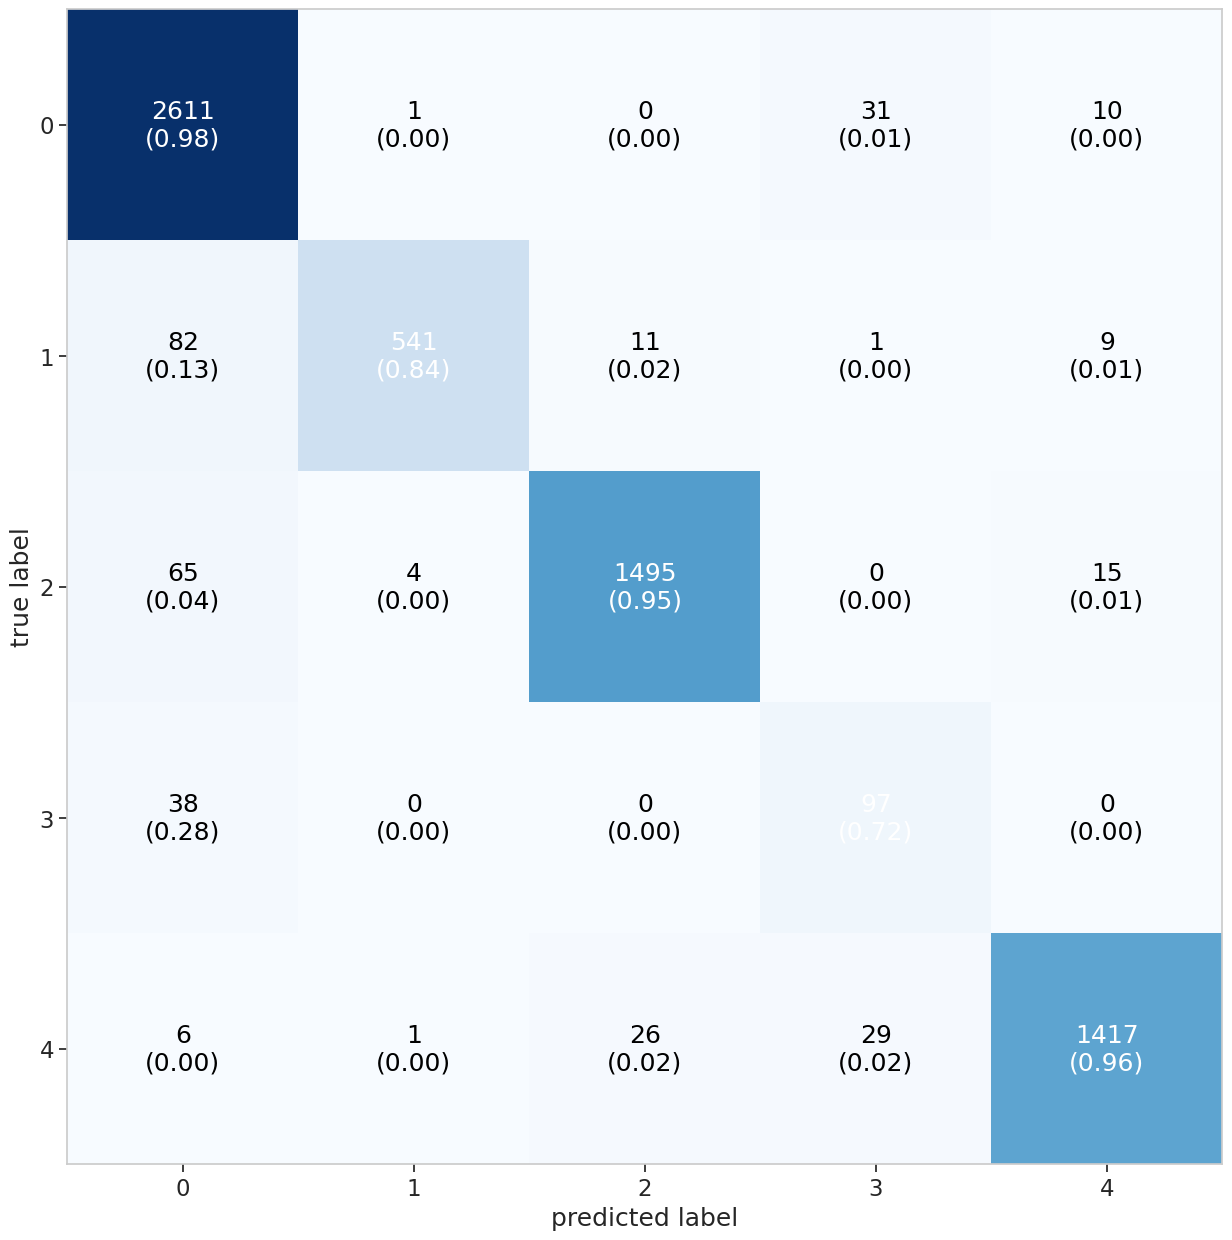

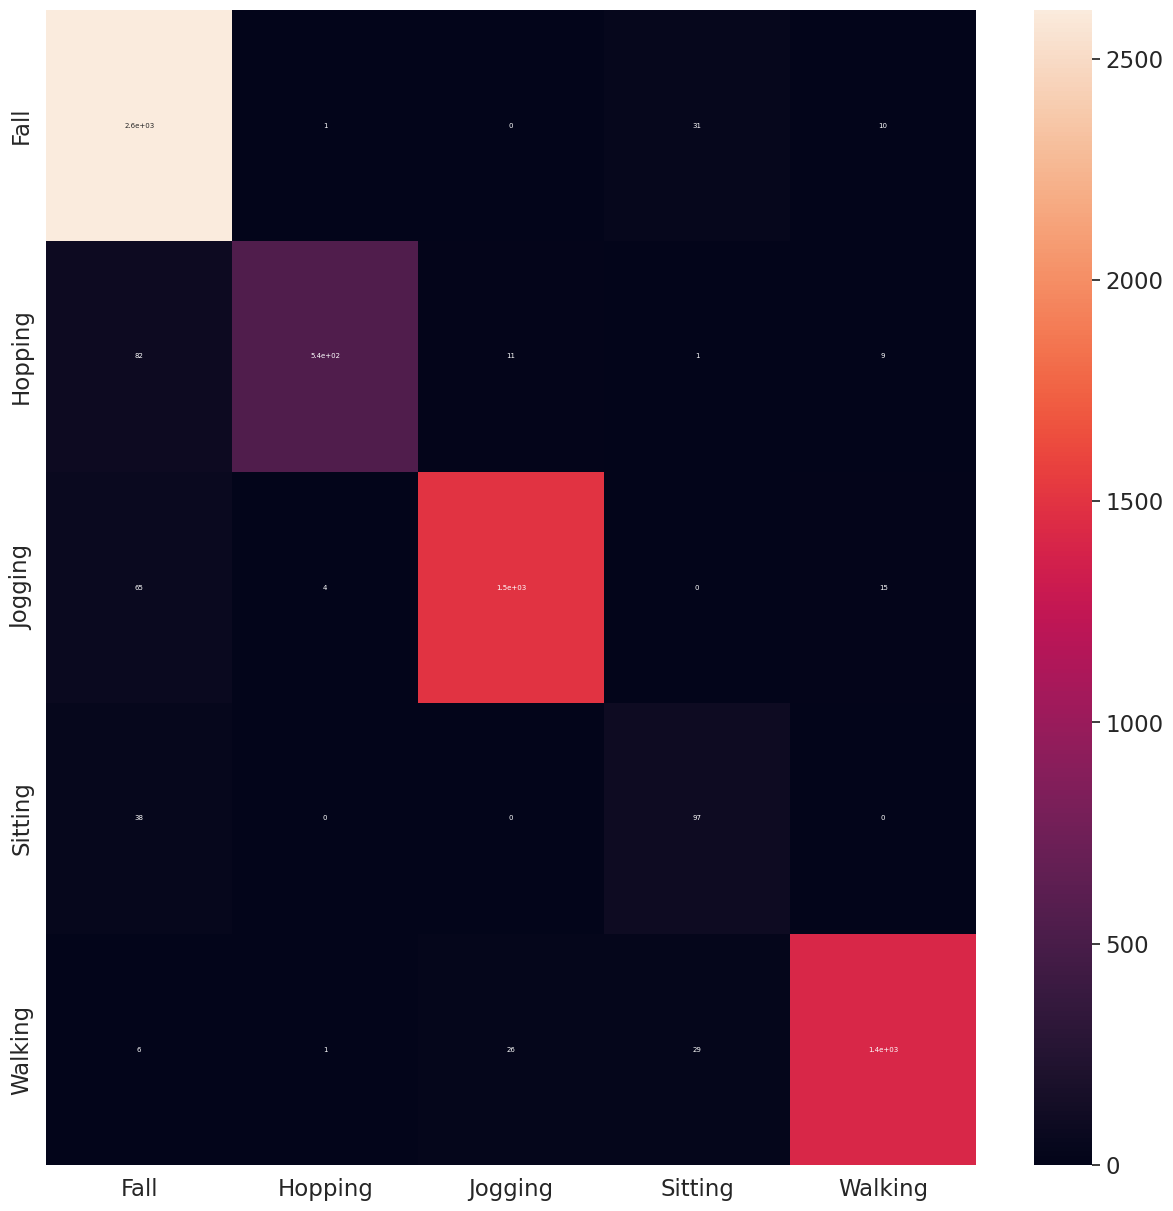

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

rounded_labels=np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(rounded_labels, y_pred);
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(15,15));


import seaborn as sn
plt.figure(figsize=(15,15))
array = confusion_matrix(rounded_labels,y_pred);
df_cm = pd.DataFrame(array, range(5),range(5));
df_cm.columns = ["Fall", "Hopping", "Jogging", "Sitting", "Walking"]
df_cm.index = df_cm.columns = ["Fall", "Hopping", "Jogging", "Sitting", "Walking"]

#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 5},yticklabels=(["Fall", "Hopping", "Jogging", "Sitting", "Walking"]));# font size
plt.show();

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(rounded_labels, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9318    0.9842    0.9573      2653
           1     0.9890    0.8401    0.9085       644
           2     0.9758    0.9468    0.9611      1579
           3     0.6139    0.7185    0.6621       135
           4     0.9766    0.9581    0.9672      1479

    accuracy                         0.9493      6490
   macro avg     0.8974    0.8895    0.8912      6490
weighted avg     0.9518    0.9493    0.9495      6490



In [ ]:
def create_dataset2(X, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(X)-time_steps, step):
    v = X.iloc[i: (i+time_steps)].values
    Xs.append(v)
  return np.array(Xs)

funzione a cui passo nome file csv di un utente e che da in pasto i dati dei sensori al modello per ottenere le predizioni per ogni riga

In [ ]:
def predict(file_name):
  csv = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file_name, index_col=None).drop(columns=['Unnamed: 0'])
  print(csv)
  scaler.fit(csv[scale_columns])#X,Y,Z
  csv.loc[:, scale_columns] = scaler.transform(csv[scale_columns].to_numpy())

  X_train_m = create_dataset2(csv[['X', 'Y', 'Z']], TIME_STEPS, 1)

  X_train_m = X_train_m.reshape(X_train_m.shape[0], X_train_m.shape[1], X_train_m.shape[2], 1)

  return model.predict(X_train_m),  np.argmax(model.predict(X_train_m), axis=-1)

modifica il vettore ottenuto dalla predizione, da essere formato da soli numeri che indicano le classi di appartenenza, vengono tradotte nelle corrispondenti attività che dipendono dal dataset

In [ ]:
def translate(vett):
  print(vett)
  translated_vett = []

  for i in range(0,len(vett)):
    if(vett[i]==0):
      translated_vett.append('Sitting')
    elif(vett[i]==1):
      translated_vett.append('Jogging')
    elif(vett[i]==2):
      translated_vett.append('Fall')
    elif(vett[i]==3):
      translated_vett.append('Hopping')
    elif(vett[i]==4):
      translated_vett.append('Walking')

  return translated_vett

stampa una resoconto delle righe incontrate, cioè la somma di ogni colonna(attività), non è direttamente utile ai fini dell applicazione

In [ ]:
def printer(predicted_vett):
  df_activity = pd.DataFrame(predicted_vett)
  df_activity.columns=["Sitting", "Jogging", "Fall", "Hopping", "Walking"]
  print(df_activity)
  print(np.sum(df_activity['Sitting']))
  print(np.sum(df_activity['Jogging']))
  print(np.sum(df_activity['Fall']))
  print(np.sum(df_activity['Hopping']))
  print(np.sum(df_activity['Walking']))

  print(np.sum(df_activity['Sitting']+df_activity['Jogging']+df_activity['Fall']+df_activity['Hopping']+df_activity['Walking']))

questa funzione prende in input il nome del file csv e il vettore delle attività tradotto e lo inserisce in nuova colonna del file csv di partenza dell utente stesso. Questo viene poi salvato

In [ ]:
def save2(file_name, predicted_vett):
  csv = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file_name, index_col=None).drop(columns=['Unnamed: 0'])
  predicted_user = csv
  predicted_user = predicted_user.drop(predicted_user.index[len(predicted_user)-151:len(predicted_user)])

  predicted_user['PredictedActivity']=predicted_vett
  w1,w2 = file_name.split('.')

  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B')

  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B/completi')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B/completi')

  predicted_user.to_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B/completi/%s_Predicted.csv' % w1)
  return predicted_user

Questa funzione crea un array con tanti elementi quante sono le schermate a cui l'utente ha partecipato. in particolare ogni elemento definisce l'ultima riga del file per schermata

In [ ]:
def find_activity(predicted_user):
  interval = []
  for row in range(0,len(predicted_user)-1):
    if(predicted_user['NameActivity'].iloc[row]!=predicted_user['NameActivity'].iloc[row+1]):
      interval.append(row)

  return interval

funzione che calcola percentuali di attività svolte rispetto al totale

In [ ]:
def percentage(row, resoconto):
  falling_sum = np.sum(resoconto['Fall'])
  hopping_sum = np.sum(resoconto['Hopping'])
  jogging_sum = np.sum(resoconto['Jogging'])
  sitting_sum = np.sum(resoconto['Sitting'])
  walking_sum = np.sum(resoconto['Walking'])

  tot = falling_sum+hopping_sum+jogging_sum+sitting_sum+walking_sum

  resoconto.at[row,'NameActivity'] = 'Statistica'
  resoconto.at[row,"Sitting"] = (sitting_sum/tot)*100
  resoconto.at[row,"Jogging"] = (jogging_sum/tot)*100
  resoconto.at[row,"Fall"] = (falling_sum/tot)*100
  resoconto.at[row,"Hopping"] = (hopping_sum/tot)*100
  resoconto.at[row,"Walking"] = (walking_sum/tot)*100

crea nuova dataframe contenente tante schermate quante sono state quelle del questionario svolte e per ognuna riporta il numero di righe relative ad ogni attività

In [ ]:
def count_activities(data):
    counts = Counter(data)
    labels, values = zip(*counts.items())
    return labels, values

def calculate_reso(i, title, labels, values, resoconto):
    resoconto.at[i, 'NameActivity'] = title
    for j in range(len(labels)):
        if labels[j] in ["Fall", "Hopping", "Jogging", "Sitting", "Walking"]:
            resoconto.at[i, labels[j]] = values[j]

def total_activity(file_name, predicted_user, interval):
  resoconto = pd.DataFrame(columns = ["NameActivity","Sitting", "Jogging", "Fall", "Hopping", "Walking"])
  if(len(interval)>0):
    temp = predicted_user['PredictedActivity'].iloc[0:interval[0]].values
    title = predicted_user['NameActivity'].iloc[0]

    labels, values = count_activities(temp)

    indSort = np.argsort(values)[::-1]

    calculate_reso(0, title, labels, values, resoconto)

    for i in range(1,len(interval)-1):
      temp = predicted_user['PredictedActivity'].iloc[interval[i]:interval[i+1]].values
      title = predicted_user['NameActivity'].iloc[interval[i]]

      labels, values = count_activities(temp)

      indSort = np.argsort(values)[::-1]

      calculate_reso(i, title, labels, values, resoconto)

    percentage(i+1, resoconto)
  else:
    temp = predicted_user['PredictedActivity'].values
    title = predicted_user['NameActivity'].iloc[0]

    labels, values = count_activities(temp)

    indSort = np.argsort(values)[::-1]

    calculate_reso(0, title, labels, values, resoconto)

    percentage(1, resoconto)

  w1,w2 = file_name.split('.')
  if(not os.path.isdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B/reso')):
    os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B/reso')
  resoconto.to_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B/reso/%s.csv' % w1)

In [ ]:
for file in os.listdir('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti'):
  if(not os.path.exists('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/3B/reso/%s' % file) and file.endswith('.csv')):
    print(file)
    df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/mmsa/Test3/csv_estratti/%s' % file)
    if(df.shape[0]>151):
      df_predicted, predicted_vett = predict(file)
      print('\n')
      translated_vett = translate(predicted_vett)
      print('\n')
      printer(df_predicted)
      print('\n')
      predicted_user = save2(file, translated_vett)
      print('\n')
      interval_activity = find_activity(predicted_user)
      print('\n')
      total_activity(file, predicted_user, interval_activity)
      print('\n\n\n')
    else:
      print(df.shape)
      print('Troppo piccolo')
  else:
    print('File %s già creato' % file)

__sensor_1676620069247526816_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
__sensor_1676620040533257101_ACCELEROMETER.csv
(0, 5)
Troppo piccolo
File __sensor_1676620060184751035_ACCELEROMETER.csv già creato
File __sensor_1676620017580120525_ACCELEROMETER.csv già creato
File __sensor_1676620017425216196_ACCELEROMETER.csv già creato
File __sensor_1676620014402054427_ACCELEROMETER.csv già creato
File __sensor_1676620014011159764_ACCELEROMETER.csv già creato
__sensor_1676619998240593006_ACCELEROMETER.csv
                             NameActivity         X         Y         Z
0              ['accelerometer_Video_1 ']  0.125113  0.018525  0.504010
1              ['accelerometer_Video_1 ']  0.174405 -0.013169  0.364552
2              ['accelerometer_Video_1 '] -0.132839  0.019639  0.327630
3              ['accelerometer_Video_1 '] -0.075514  0.052143  0.263232
4              ['accelerometer_Video_1 ']  0.220938  0.086958  0.452027
...                                   ...       ...       ...       

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1227/1227 [==============================] - 7s 6ms/step


[3 3 3 ... 1 1 1]


        Walking   Jogging   Hopping   Sitting      Fall
0      0.154331  0.219326  0.184084  0.241219  0.201040
1      0.166615  0.212826  0.191048  0.221696  0.207816
2      0.166974  0.221199  0.185822  0.228339  0.197667
3      0.163918  0.242892  0.173867  0.243332  0.175991
4      0.137631  0.222766  0.204556  0.247409  0.187638
...         ...       ...       ...       ...       ...
39241  0.154596  0.230828  0.190993  0.250242  0.173341
39242  0.154434  0.235577  0.182438  0.249251  0.178299
39243  0.140798  0.258938  0.186231  0.241113  0.172920
39244  0.141937  0.259519  0.202477  0.229438  0.166628
39245  0.155037  0.232054  0.215317  0.224219  0.173373

[39246 rows x 5 columns]
5641.3447
10175.244
8165.246
8941.65
6322.513
39246.0










File __sensor_1676620019950815689_ACCELEROMETER.csv già creato
File __sensor_1676620025027387818_ACCELEROMETER.csv già creato
File __sensor_1676620036470540022